# Density interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sys 
sys.path.append('..')

import gleam as gm
from gleam.dlv import DiscreteLocalVolatilityModel, delta, augment_data
from gleam.black_scholes import price

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
def jordinson_scaling(sigma, t, n, delta):
    i = np.arange(n).reshape(-1, 1)
    a = delta*(2*(i + 1) - (n + 1)) / (n + 1)
    return np.exp(a*sigma*t.T**0.5 - 0.5*sigma**2*t.T)

In [3]:
spot = np.array([1])
tau = np.zeros((2, 7))
tau[0] = 0.25
tau[1] = 10
sigma = np.ones_like(1) * 0.2

delta = 3
strikes = np.zeros_like(tau)
strikes[0] = jordinson_scaling(sigma, tau[0:1], 7, delta)[:, 0]
strikes[1] = jordinson_scaling(sigma, tau[1:2], 7, delta)[:, 0]

prices = price(spot, strikes, tau, sigma)

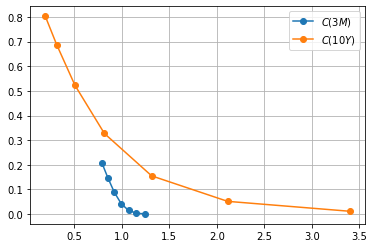

In [4]:
plt.plot(strikes[0], prices[0], '-o', label=r'$C(3M)$')
plt.plot(strikes[1], prices[1], '-o', label=r'$C(10Y)$')
plt.legend()
plt.grid()
plt.show()

Calibrate discrete local volatilities

In [5]:
dlv = DiscreteLocalVolatilityModel()
dlv.calibrate(
    prices=prices,
    strikes=strikes,
    maturities=tau, 
    bounds=np.array([[0.1, 2.5], [0.1, 2.5]]), 
)

Compute interpolated density 

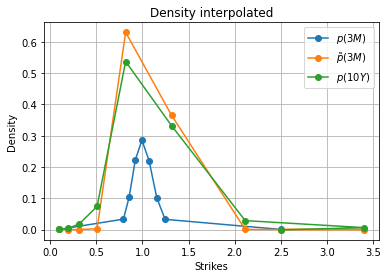

In [6]:
sl0 = dlv.slices[0]
sl1 = dlv.slices[1]
p_3m = sl1.density
p_3m_tilde = sl1.psi@sl1.omega@sl1.density
p_10y = sl1.transition_op(2)@sl1.density

plt.plot(sl1.k[1:-1], p_3m, '-o', label=r'$p(3M)$')
plt.plot(sl1.k_next[1:-1], p_3m_tilde, '-o', label=r'$\tilde{p}(3M)$')
plt.plot(sl1.k_next[1:-1], p_10y, '-o', label=r'$p(10Y)$')
plt.legend()
plt.grid()
plt.xlabel('Strikes')
plt.ylabel('Density')
plt.title('Density interpolated')
plt.show()

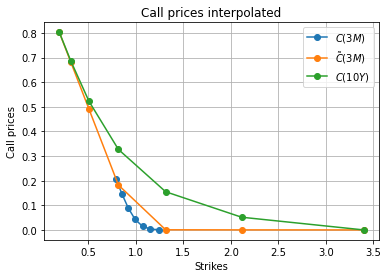

In [7]:
k = np.zeros((3, 7))
t = np.zeros((3, 7)) 
k[0] = strikes[0]
k[1] = strikes[1]
k[2] = strikes[1]
t[0] = tau[0]
t[1] = tau[0]
t[2] = tau[1]
prices_interpolated = dlv.get_prices(k, t)

plt.plot(k[0], prices_interpolated[0], '-o', label=r'$C(3M)$')
plt.plot(k[1], prices_interpolated[1], '-o', label=r'$\tilde{C}(3M)$')
plt.plot(k[2], prices_interpolated[2], '-o', label=r'$C(10Y)$')
plt.legend()
plt.grid()
plt.xlabel('Strikes')
plt.ylabel('Call prices')
plt.title('Call prices interpolated')
plt.show()